# Using batch GP with nodata values: nodata replacement method that works with all kernel types?

**This notebook follows the "*speed_multiple_gp_1d*" notebook on the performance of GP prediction for multiple 1D input data.**

In that previous notebook, we found the most efficient method to be **batch GP** in GPyTorch. However, this method expects fixed vector lengths of size K for a batch of size N. In practice, for geospatial data (a time series, for instance), it is rarely the case to have a fixed size for vector K due to different data density and gaps. Data gaps are represented with nodata values (i.e. NaNs), not supported by GP algorithms that will simply predict NaNs everywhere.

In this notebook, we investigate **nodata replacement methods to "trick" 1D batch Gaussian Process regression to correctly predict with nodata values** by:
1. **"Mean at far coordinate replacement": Replacing nodata values by the GP mean function value**, and **fixing their coordinates far from the prediction window** based on GP kernel lengthscales (i.e. correlation ranges),
2. **"Summed-error at single coordinate replacement": Making all nodata values a real observed value at the same coordinate than the real value, but with larger measurement errors that quadratically combine into the original error of this point**, which requires to define an heteroscedastic input (variable measurement error).

To do this, **we will compare prediction of the batch GP with NaN input values and nodata replacement methods with that of a 1D GP with only the valid input values**. We do this for both stationary and non-stationary kernels, to ensure all types of prediction are supported.

We call functions living in:
- */spacetime/models.py* to define the models and predict on input data with **fixed covariance parameters**.
- */spacetime/scaling.py* to use routines specific to scaling.

**There is no training, we are only interested in prediction! Covariance is defined arbitrarily.**

In [1]:
import os
import sys
import numpy as np
import time
import pandas as pd
import matplotlib as mpl
import matplotlib.pyplot as plt
mpl.rcParams['figure.dpi'] = 150

sys.path.insert(0, "..")
import spacetime.models
import spacetime.scaling

## Create example 1D data with nodatas (NaNs)

We use the example data below from https://geostat-framework.readthedocs.io/projects/pykrige/en/stable/examples/05_kriging_1D.html (initially taken from https://blog.dominodatalab.com/fitting-gaussian-process-models-python/), and add nodata values randomly.

In [2]:
# Construct 1D data
data = np.array([
     [-5.01, 1.06], [-4.90, 0.92], [-4.82, 0.35], [-4.69, 0.49], [-4.56, 0.52],
     [-4.52, 0.12], [-4.39, 0.47], [-4.32,-0.19], [-4.19, 0.08], [-4.11,-0.19],
     [-4.00,-0.03], [-3.89,-0.03], [-3.78,-0.05], [-3.67, 0.10], [-3.59, 0.44],
     [-3.50, 0.66], [-3.39,-0.12], [-3.28, 0.45], [-3.20, 0.14], [-3.07,-0.28],
     [-3.01,-0.46], [-2.90,-0.32], [-2.77,-1.58], [-2.69,-1.44], [-2.60,-1.51],
     [-2.49,-1.50], [-2.41,-2.04], [-2.28,-1.57], [-2.19,-1.25], [-2.10,-1.50],
     [-2.00,-1.42], [-1.91,-1.10], [-1.80,-0.58], [-1.67,-1.08], [-1.61,-0.79],
     [-1.50,-1.00], [-1.37,-0.04], [-1.30,-0.54], [-1.19,-0.15], [-1.06,-0.18],
     [-0.98,-0.25], [-0.87,-1.20], [-0.78,-0.49], [-0.68,-0.83], [-0.57,-0.15],
     [-0.50, 0.00], [-0.38,-1.10], [-0.29,-0.32], [-0.18,-0.60], [-0.09,-0.49],
     [0.03 ,-0.50], [0.09 ,-0.02], [0.20 ,-0.47], [0.31 ,-0.11], [0.41 ,-0.28],
     [0.53 , 0.40], [0.61 , 0.11], [0.70 , 0.32], [0.94 , 0.42], [1.02 , 0.57],
     [1.13 , 0.82], [1.24 , 1.18], [1.30 , 0.86], [1.43 , 1.11], [1.50 , 0.74],
     [1.63 , 0.75], [1.74 , 1.15], [1.80 , 0.76], [1.93 , 0.68], [2.03 , 0.03],
     [2.12 , 0.31], [2.23 ,-0.14], [2.31 ,-0.88], [2.40 ,-1.25], [2.50 ,-1.62],
     [2.63 ,-1.37], [2.72 ,-0.99], [2.80 ,-1.92], [2.83 ,-1.94], [2.91 ,-1.32],
     [3.00 ,-1.69], [3.13 ,-1.84], [3.21 ,-2.05], [3.30 ,-1.69], [3.41 ,-0.53],
     [3.52 ,-0.55], [3.63 ,-0.92], [3.72 ,-0.76], [3.80 ,-0.41], [3.91 , 0.12],
     [4.04 , 0.25], [4.13 , 0.16], [4.24 , 0.26], [4.32 , 0.62], [4.44 , 1.69],
     [4.52 , 1.11], [4.65 , 0.36], [4.74 , 0.79], [4.84 , 0.87], [4.93 , 1.01],
     [5.02 , 0.55]
])

# Randomly keep 50 points, make others NaNs
np.random.seed(42)
ind_subsample_data = np.random.choice(len(data), 20, replace=False)
data[ind_subsample_data, 1] = np.nan

# Output grid
gridx = np.linspace(-6, 6, 200)

## Case 1: homoscedastic input (constant measurement error) and "mean at far coordinate" replacement

For this case, we only test Method 1 (as Method 2 requires a variable measurement error).

### Replacement strategy

We apply method 1, that redefines nodata as mean of all at a far coordinate, and visualize it!

In [3]:
# Baseline: Predict output on valid values
ind_valid = np.isfinite(data[:, 1])
data_valid = data[ind_valid, :]

# Method 1: Replace nodata values by the mean at a far coordinate
data_tricked = data.copy()
data_tricked[~ind_valid, 0] = 100  # Coordinate 100 is way off the prediction window of [-6, +6] and the lengthscale of 2 we're using
data_tricked[~ind_valid, 1] = np.nanmean(data[:, 1]) # Replace value by the mean

(-5.0, 5.0)

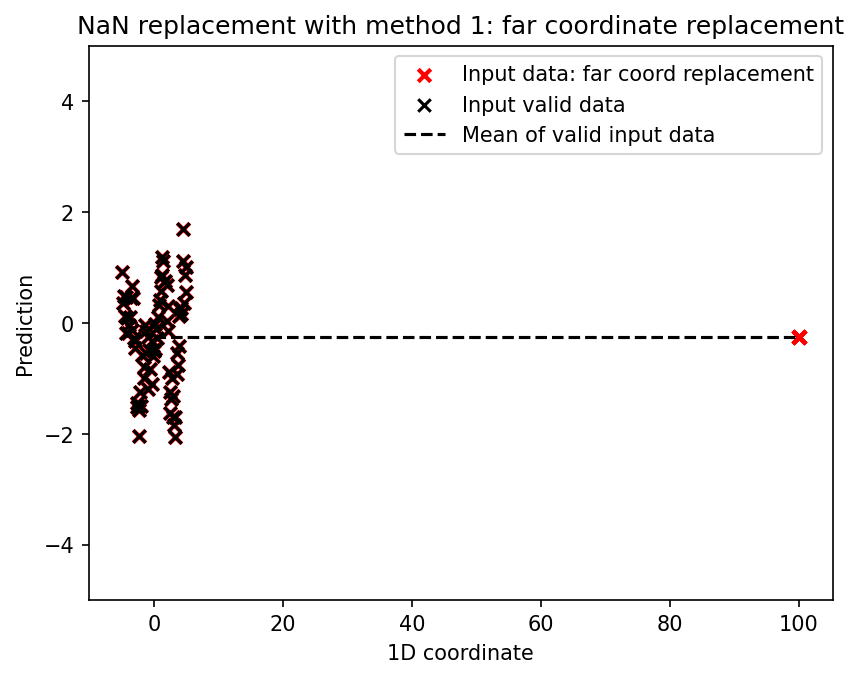

In [4]:
plt.figure()
plt.scatter(data_tricked[:, 0], data_tricked[:, 1], c="red", marker="x", linewidth=2, label="Input data: far coord replacement")
plt.scatter(data_valid[:, 0], data_valid[:, 1], c="black", marker="x", label="Input valid data")
plt.hlines(np.nanmean(data_valid[:, 1]), xmin=0, xmax=100, linestyle="dashed", color="black", label="Mean of valid input data")
plt.xlabel("1D coordinate")
plt.ylabel("Prediction")
plt.title("NaN replacement with method 1: far coordinate replacement")
plt.legend()
plt.ylim((-5, 5))

### Stationary kernels

We use a simple RBF kernel as example of stationary kernel.

In [5]:
# Define the 1D prediction grid, and covariance model
variogram_model = {"model_name": "RBF", "lengthscale": 2, "outputscale": 2, "noise_level": 0.01}

In [6]:
# Predictions
y_gpy, sig_gpy, m_gpy = spacetime.models.gpytorch_predict_1d(variogram_model=variogram_model, gridx=gridx, data=data_valid)
y_gpy1, sig_gpy1, m_gpy1 = spacetime.models.gpytorch_predict_1d(variogram_model=variogram_model, gridx=gridx, data=data_tricked)

(-5.0, 5.0)

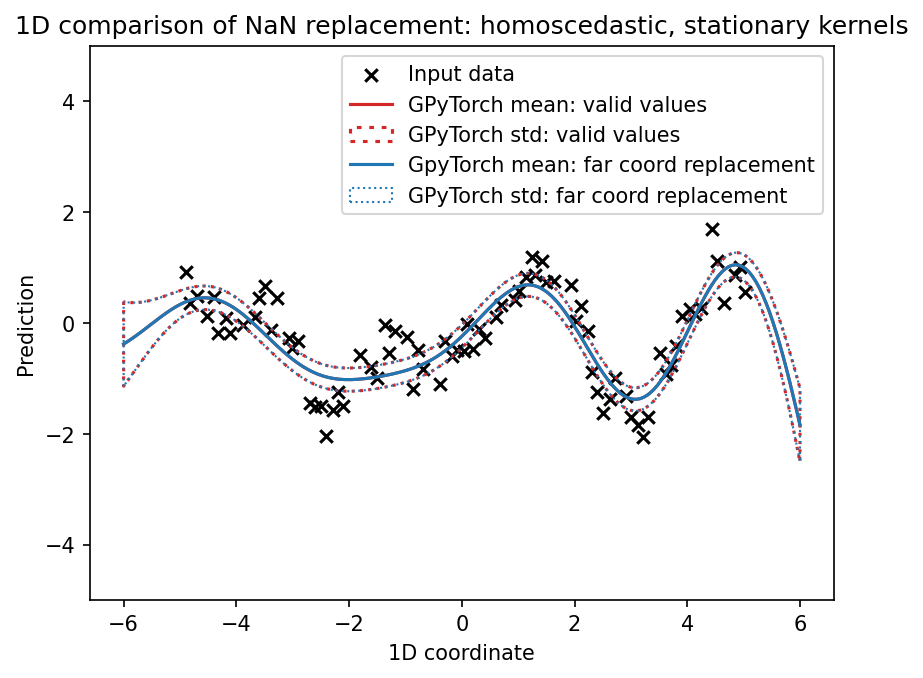

In [7]:
plt.figure()
plt.scatter(data_valid[:, 0], data_valid[:, 1], c="black", marker="x", label="Input data")
plt.plot(gridx, y_gpy, c="tab:red", linewidth=1.5, label="GPyTorch mean: valid values")
plt.fill_between(gridx, y_gpy - 2*sig_gpy, y_gpy + 2*sig_gpy, edgecolor="tab:red", facecolor="None",linestyle="dotted", linewidth=1.5, label="GPyTorch std: valid values")
plt.plot(gridx, y_gpy1, c="tab:blue", label="GpyTorch mean: far coord replacement")
plt.fill_between(gridx, y_gpy1+ 2*sig_gpy1, y_gpy1-2*sig_gpy1, edgecolor="tab:blue", facecolor="None",linestyle="dotted", label="GPyTorch std: far coord replacement")
plt.xlabel("1D coordinate")
plt.ylabel("Prediction")
plt.title("1D comparison of NaN replacement: homoscedastic, stationary kernels")
plt.legend()
plt.ylim((-5, 5))

Method 1 is working well for a stationary kernel!

### Non-stationary kernels

We add a linear kernel (example of non-stationary kernel) to all prediction by passing an *add_linear* argument.

In [8]:
# Baseline: Predict only on valid values
y_gpy_ns, sig_gpy_ns, m_gpy_ns = spacetime.models.gpytorch_predict_1d(variogram_model=variogram_model, gridx=gridx, data=data_valid, add_linear=True)
# Method 1: Replace nodata values by the mean at a far coordinate
y_gpy1_ns, sig_gpy1_ns, m_gpy1_ns = spacetime.models.gpytorch_predict_1d(variogram_model=variogram_model, gridx=gridx, data=data_tricked, add_linear=True)

/home/atom/miniconda3/envs/spacetime-dev/lib/python3.11/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-08 to the diagonal
  warnings.warn(


(-5.0, 5.0)

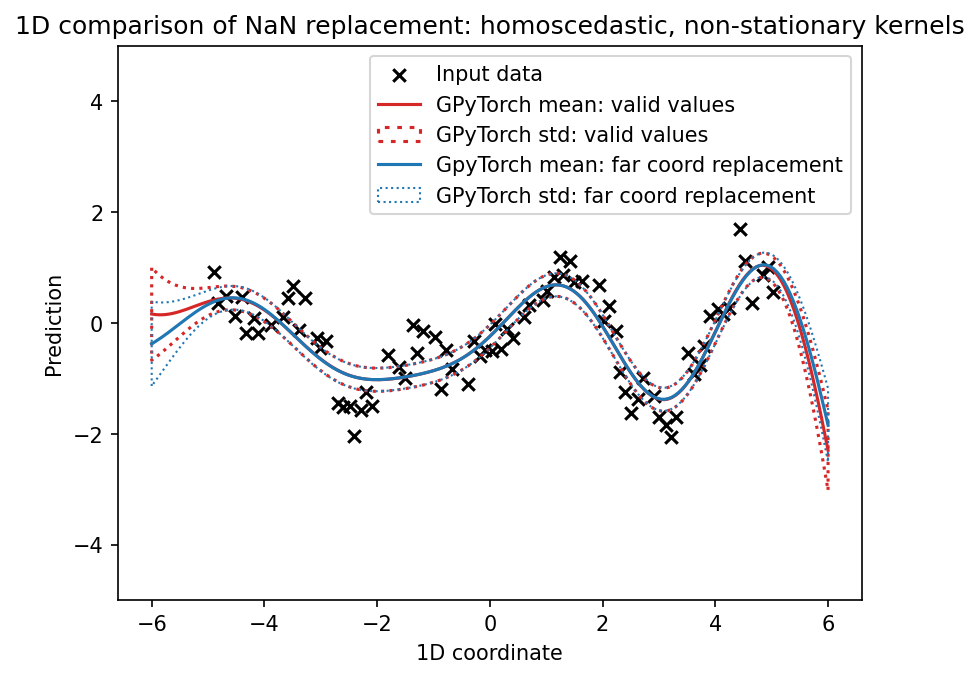

In [9]:
plt.figure()
plt.scatter(data_valid[:, 0], data_valid[:, 1], c="black", marker="x", label="Input data")
plt.plot(gridx, y_gpy_ns, c="tab:red", linewidth=1.5, label="GPyTorch mean: valid values")
plt.fill_between(gridx, y_gpy_ns - 2*sig_gpy_ns, y_gpy_ns + 2*sig_gpy_ns, edgecolor="tab:red", facecolor="None",linestyle="dotted", linewidth=1.5, label="GPyTorch std: valid values")
plt.plot(gridx, y_gpy1_ns, c="tab:blue", label="GpyTorch mean: far coord replacement")
plt.fill_between(gridx, y_gpy1_ns+ 2*sig_gpy1_ns, y_gpy1_ns-2*sig_gpy1_ns, edgecolor="tab:blue", facecolor="None",linestyle="dotted", label="GPyTorch std: far coord replacement")
plt.xlabel("1D coordinate")
plt.ylabel("Prediction")
plt.title("1D comparison of NaN replacement: homoscedastic, non-stationary kernels")
plt.legend()
plt.ylim((-5, 5))

**The replacement by the mean at a far coordinate (Method 1) does not work reliably on non-stationary kernels**. All the mean value points at coordinate 100 are biasing the linear kernel...

Let's investigate Method 2 using a variable error input!

## Case 2: heteroscedastic input (variable measurement error) and "summed-error" replacement

We create a variable measurement error for every point.

We only test Method 2, as we know Method 1 will not perform properly for non-stationary kernels.

In [10]:
# Add heteroscedasticity: variable measurement error
np.random.seed(42)
err = np.abs(np.random.normal(loc=0.5, scale=0.2, size=len(data)))

## Replacement strategy

In [11]:
# Baseline: Predict output on valid values
ind_valid = np.isfinite(data[:, 1])
data_valid = data[ind_valid, :]
err_valid = err[ind_valid]

# Method 2: Let's stack all nodata at the coordinate of the first value, and enlarge its error for the sum of the samples (quadratic sum of error) to match
data_cheat = data.copy()
err_cheat = err.copy()
ind_first = ind_valid.argmax()  # First True value is argmax
# Copy coordinate and value of first valid value to all NaNs
data_cheat[~ind_valid, 0] = data[ind_first, 0]  # Copy coordinate
data_cheat[~ind_valid, 1] = data[ind_first, 1]  # Copy value
# Give larger, equal errors that match the original error in quadratic sum
nb_invalid = np.count_nonzero(~ind_valid)
err_first = np.sqrt(err[ind_first]**2 * (nb_invalid+1))  # Invalid points + 1 for the original point
err_cheat[~ind_valid] = err_first
err_cheat[ind_first] = err_first

(-5.0, 5.0)

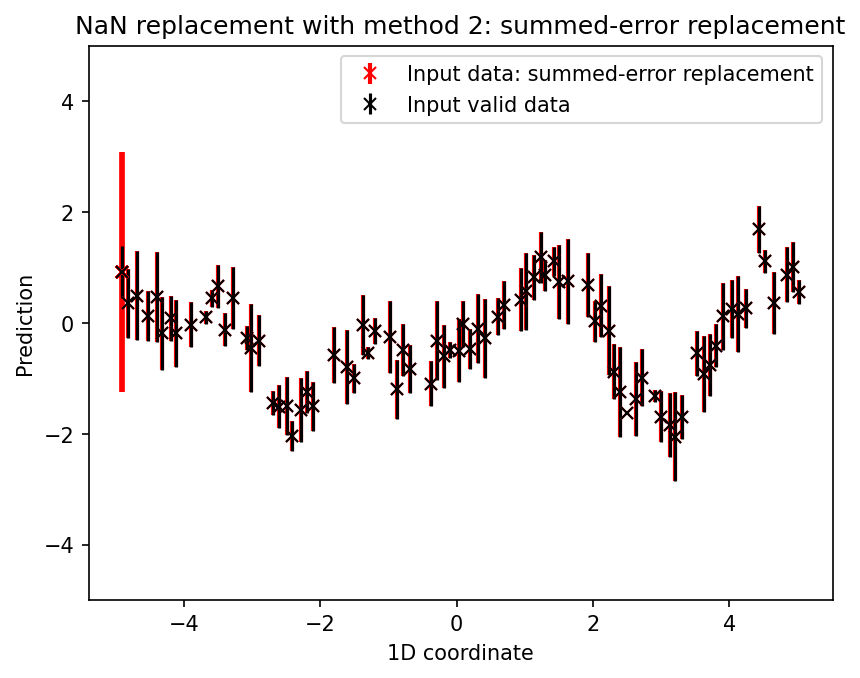

In [12]:
plt.figure()
plt.errorbar(data_cheat[:, 0], data_cheat[:, 1], yerr=err_cheat, linestyle="", c="red", marker="x", linewidth=2, label="Input data: summed-error replacement")
plt.errorbar(data_valid[:, 0], data_valid[:, 1], yerr=err_valid, linestyle="", c="black", marker="x", label="Input valid data")
plt.xlabel("1D coordinate")
plt.ylabel("Prediction")
plt.title("NaN replacement with method 2: summed-error replacement")
plt.legend()
plt.ylim((-5, 5))

## Stationary kernels

We evaluate the GP with variable error only on valid values, and the one with Method 2 for replacement into existing value with upsampled error.

For Method 2, as we introduce many values that are not the mean of all points, we have to force the mean of the GP (here by passing a *force_mean* argument).

In [13]:
# We add an "_e" subscript for "error"
y_gpy_e, sig_gpy_e, m_gpy_e = spacetime.models.gpytorch_predict_1d(variogram_model=variogram_model, gridx=gridx, data=data_valid, err=err_valid)
# For method 2 we need to force the original mean of the data in the GP
mean_y = np.nanmean(data_valid[:, 1])
y_gpy2_e, sig_gpy2_e, m_gpy2_e = spacetime.models.gpytorch_predict_1d(variogram_model=variogram_model, gridx=gridx, data=data_cheat, err=err_cheat, force_mean=mean_y)

/home/atom/miniconda3/envs/spacetime-dev/lib/python3.11/site-packages/gpytorch/likelihoods/gaussian_likelihood.py:300: GPInputWarning: You have passed data through a FixedNoiseGaussianLikelihood that did not match the size of the fixed noise, *and* you did not specify noise. This is treated as a no-op.
  warnings.warn(


(-5.0, 5.0)

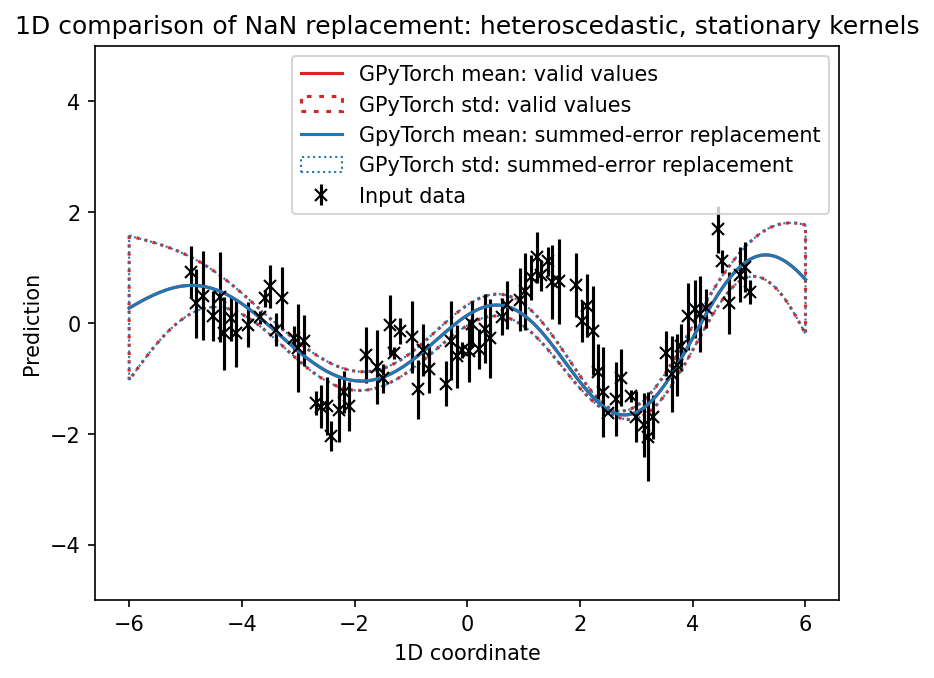

In [14]:
plt.figure()
plt.errorbar(data_valid[:, 0], data_valid[:, 1], yerr=err_valid, c="black", marker="x", linestyle="", label="Input data")
plt.plot(gridx, y_gpy_e, c="tab:red", linewidth=1.5, label="GPyTorch mean: valid values")
plt.fill_between(gridx, y_gpy_e - 2*sig_gpy_e, y_gpy_e + 2*sig_gpy_e, edgecolor="tab:red", facecolor="None",linestyle="dotted", linewidth=1.5, label="GPyTorch std: valid values")
plt.plot(gridx, y_gpy2_e, c="tab:blue", label="GpyTorch mean: summed-error replacement")
plt.fill_between(gridx, y_gpy2_e+ 2*sig_gpy2_e, y_gpy2_e - 2*sig_gpy2_e, edgecolor="tab:blue", facecolor="None",linestyle="dotted", label="GPyTorch std: summed-error replacement")
plt.xlabel("1D coordinate")
plt.ylabel("Prediction")
plt.title("1D comparison of NaN replacement: heteroscedastic, stationary kernels")
plt.legend()
plt.ylim((-5, 5))

### Non-stationary kernels

In [15]:
# Baseline: Predict only on valid values
y_gpy_ens, sig_gpy_ens, m_gpy_ens = spacetime.models.gpytorch_predict_1d(variogram_model=variogram_model, gridx=gridx, data=data_valid, err=err_valid, add_linear=True)
# Method 1: Replace nodata values by the mean at a far coordinate
y_gpy2_ens, sig_gpy2_ens, m_gpy2_ens = spacetime.models.gpytorch_predict_1d(variogram_model=variogram_model, gridx=gridx, data=data_cheat, err=err_cheat, force_mean=mean_y, add_linear=True)

(-5.0, 5.0)

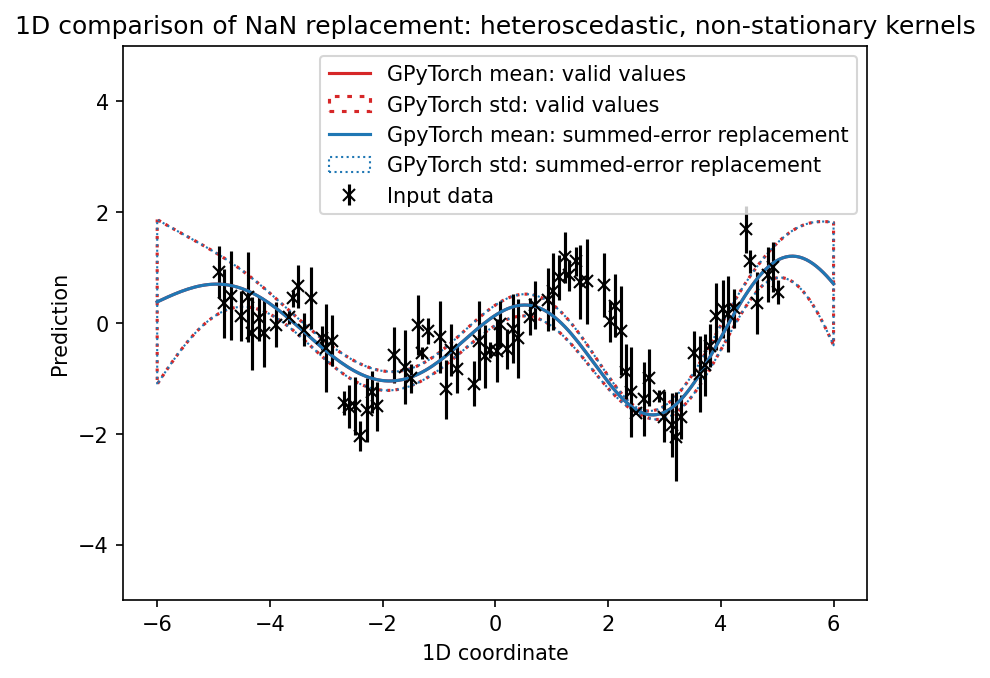

In [16]:
plt.figure()
plt.errorbar(data_valid[:, 0], data_valid[:, 1], yerr=err_valid, c="black", marker="x", linestyle="", label="Input data")
plt.plot(gridx, y_gpy_ens, c="tab:red", linewidth=1.5, label="GPyTorch mean: valid values")
plt.fill_between(gridx, y_gpy_ens - 2*sig_gpy_ens, y_gpy_ens + 2*sig_gpy_ens, edgecolor="tab:red", facecolor="None",linestyle="dotted", linewidth=1.5, label="GPyTorch std: valid values")
plt.plot(gridx, y_gpy2_ens, c="tab:blue", label="GpyTorch mean: summed-error replacement")
plt.fill_between(gridx, y_gpy2_ens+ 2*sig_gpy2_ens, y_gpy2_ens-2*sig_gpy2_ens, edgecolor="tab:blue", facecolor="None",linestyle="dotted", label="GPyTorch std: summed-error replacement")
plt.xlabel("1D coordinate")
plt.ylabel("Prediction")
plt.title("1D comparison of NaN replacement: heteroscedastic, non-stationary kernels")
plt.legend()
plt.ylim((-5, 5))

**Method 2 appears to perform well for both stationary and non-stationary kernels!**

After performing additional tests (modifying kernel parameters, performing the summed-error replacement on an outlier that influences the fit a lot, etc), it seems that this method is fairly robust.

**We now have a solution to run batch GP on a large dataset with NaNs! :D**